In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco_modified.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 

opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
import json
from detectron2.structures import BoxMode
image_root = home_dir + "/datasets/v-coco/images/train2014"
anno_file = home_dir + "/datasets/v-coco/annotations/trainval_vcoco.json"
print(anno_file)
def load_vcoco_json(image_root, anno_file):
    json_file = os.path.join(anno_file)
    with open(json_file) as f:
        vcoco_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(vcoco_anns):
        record = {}
        record["id"] = idx
        for key, val in v.items():
            if key == "file_name":
                record[key] = os.path.join(image_root, v["file_name"])
            else:
                record[key] = val
                if key == "annotations":
                    for anno in v[key]:
                        anno["bbox_mode"] = BoxMode.XYWH_ABS
        dataset_dicts.append(record)
    return dataset_dicts

/home/djjin/Mygit/X-Decoder/datasets/v-coco/annotations/trainval_vcoco.json


In [5]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

{'PIPELINE': 'HDecoderPipeline', 'TRAINER': 'hdecoder', 'SAVE_DIR': 'data/output/test', 'base_path': '../', 'WANDB': True, 'AUX_LOSS': True, 'RESUME': False, 'WEIGHT': False, 'RESET_DATA_LOADER': False, 'RESUME_FROM': '', 'PYLEARN_MODEL': '../data/output/test/00062100/default/raw_model_states.pt', 'DONT_LOAD_MODEL': False, 'LOG_EVERY': 10, 'FIND_UNUSED_PARAMETERS': False, 'FP16': False, 'PORT': '36873', 'LOADER': {'JOINT': True, 'KEY_DATASET': 'coco'}, 'VERBOSE': True, 'MODEL': {'NAME': 'hoi_model', 'HEAD': 'hoi_head', 'MASK_ON': False, 'KEYPOINT_ON': False, 'LOAD_PROPOSALS': False, 'DIM_PROJ': 512, 'BACKBONE_DIM': 2048, 'BACKBONE': {'NAME': 'focal_dw', 'PRETRAINED': '', 'LOAD_PRETRAINED': False, 'FOCAL': {'PRETRAIN_IMG_SIZE': 224, 'PATCH_SIZE': 4, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'FOCAL_LEVELS': [3, 3, 3, 3], 'FOCAL_WINDOWS': [3, 3, 3, 3], 'DROP_PATH_RATE': 0.3, 'MLP_RATIO': 4.0, 'DROP_RATE': 0.0, 'PATCH_NORM': True, 'USE_CONV_EMBED': True, 'SCALING_MODULATOR': True, 'USE_CHEC

INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 5400 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 4.09 MiB


Dataset length: 5400
2700


[tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([ 343.7815,  876.0330, 1024.0000, 1022.5320]), tensor([262.3540, 681.4765, 750.2140, 804.9220])]
[tensor([ 96.6908, 185.6114, 162.5264, 210.0322]), tensor([0., 0., 0., 0.])]


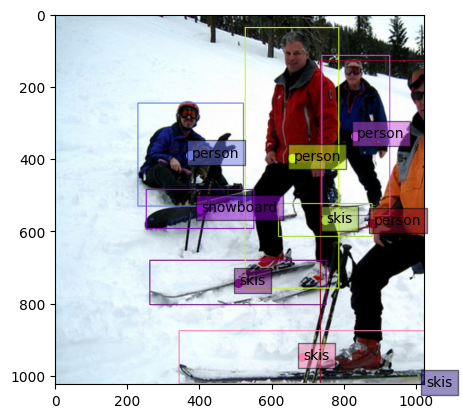

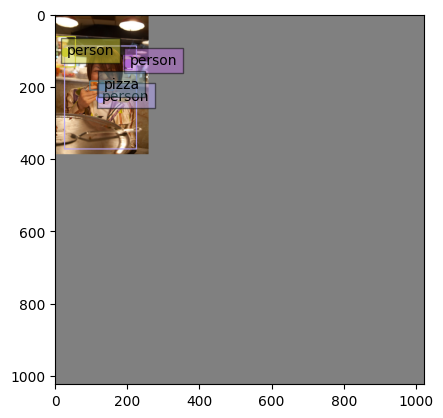

[tensor([173.6081, 273.4297, 457.2838, 764.5496]), tensor([0., 0., 0., 0.])]
[tensor([312.6364, 187.1544, 422.6386, 360.9130]), tensor([  1.3053, 259.7701, 918.0000, 571.5029]), tensor([329.2177, 407.0095, 725.0192, 578.0000]), tensor([  1.3053, 259.7701, 918.0000, 571.5029]), tensor([312.6364, 187.1544, 422.6386, 360.9130])]


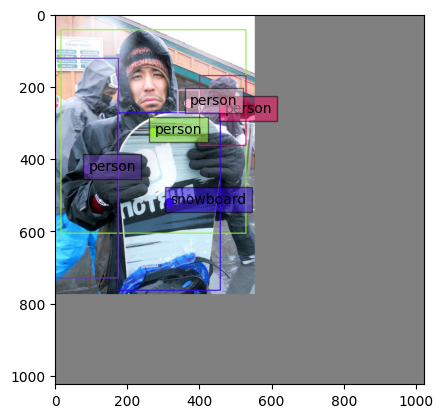

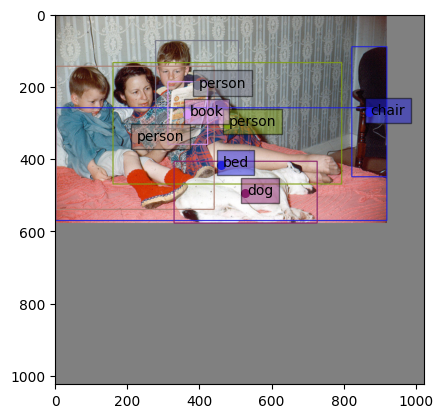

[tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.])]
[tensor([716.4474, 492.0621, 765.2751, 533.1649]), tensor([464.0121, 351.4893, 480.6355, 396.4651]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.])]


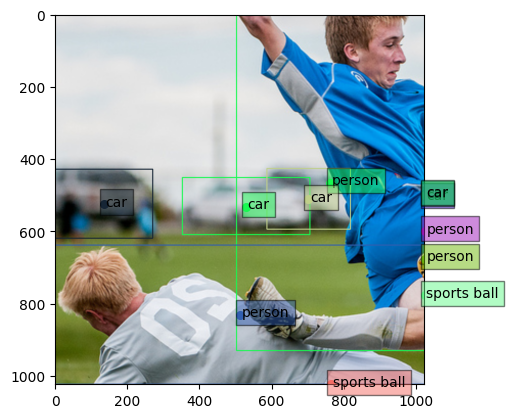

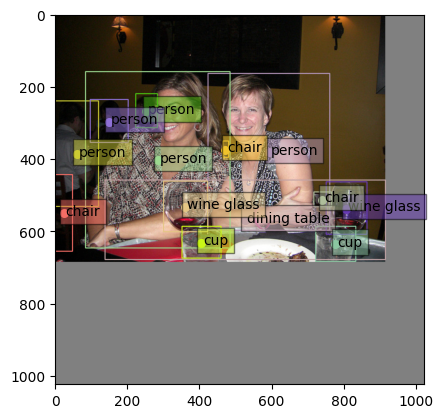

[tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([191.2274, 248.2939, 218.7003, 272.5662]), tensor([191.2274, 248.2939, 218.7003, 272.5662])]
[tensor([349.5252, 370.5119, 491.4024, 525.7672]), tensor([0., 0., 0., 0.])]


In [6]:
import cv2, random
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()

                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                obj_boxes = obj_boxes.cpu().numpy()
                classes = batch_per_image['instances'].gt_classes
                classes = classes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                labels = []
                for idx in classes:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)

                for label, box in zip(labels, obj_boxes):
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )
                
                plt.imshow(img)
                plt.show()